In [2]:
## based on https://github.com/srush/torch-golf

import numpy as np 

import torch as t
import networkx as nx
import seaborn
# import celluloid
import matplotlib.pyplot as plt
from IPython.core.display import HTML
seaborn.set_context("talk", font_scale=0.5)
plt.ioff()
from entmax.activations import sparsemax, entmax15
from entmax.root_finding import entmax_bisect


from sklearn.metrics.cluster import rand_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score


/var/folders/rg/k2drb03s1j72zwhwg8qf28l00000gn/T/ipykernel_86613/4165306235.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis', s=15)


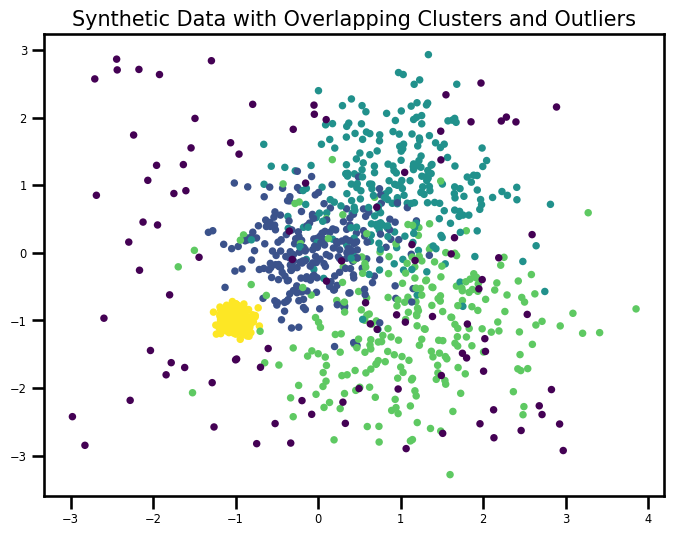

In [3]:
t.manual_seed(40)
import torch as t
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal as N
# from torch_sparsemax import sparsemax
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.datasets import make_blobs
import numpy as np

# Generate synthetic data once (consistent across seeds)
NUM_SAMPLES = 1000
NUM_FEATURES = 2
NUM_CLASSES = 4

# Generate blobs with centers close to each other
centers = [[0, 0], [1, 1], [1, -1], [-1, -1]]
cluster_std = [0.5, 0.7, 0.9, 0.11]  # Standard deviations

X_np, y_np = make_blobs(
    n_samples=NUM_SAMPLES,
    centers=centers,
    cluster_std=cluster_std,
    random_state=0
)
X = t.tensor(X_np, dtype=t.float32)
y = t.tensor(y_np, dtype=t.int64)

# Add random noise points
NUM_NOISE = 100
noise = t.rand(NUM_NOISE, NUM_FEATURES) * 6 - 3  # Uniformly between -3 and 3
X = t.cat([X, noise], dim=0)
y = t.cat([y, t.full((NUM_NOISE,), -1, dtype=t.int64)], dim=0)  # Label noise points as -1

# Define a fixed color map based on true labels for consistency
unique_labels = np.unique(y.numpy())
cmap = plt.get_cmap('viridis', len(unique_labels))
color_mapping = {label: cmap(i) for i, label in enumerate(unique_labels)}
#cmap = plt.get_cmap('Accent', len(unique_labels))
#color_mapping = {label: cmap(i) for i, label in enumerate(unique_labels)}


# Function to map cluster labels to colors based on true labels
def map_labels_to_colors(labels, y_true):
    # Create a mapping from cluster to true label
    from scipy.stats import mode
    label_mapping = {}
    for cluster in np.unique(labels):
        mask = labels == cluster
        if np.any(y_true[mask] != -1):
            # Fixed the extraction of the mode to use .item() instead of [0]
            most_common = mode(y_true[mask][y_true[mask] != -1]).mode
            if isinstance(most_common, np.ndarray):
                most_common = most_common.item()
            label_mapping[cluster] = most_common
        else:
            label_mapping[cluster] = -1  # Assign a distinct color for noise
    colors = [color_mapping.get(label_mapping[label], (0,0,0,1)) for label in labels]
    return colors

# Visualization of the data
plt.figure(figsize=(8, 6))
colors = map_labels_to_colors(y.numpy(), y.numpy())
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis', s=15)
plt.title('Synthetic Data with Overlapping Clusters and Outliers', fontsize=15)
plt.savefig('Synthetic Data with Overlapping Clusters and Outliers.png')
plt.show()




In [11]:
# Constants
BATCH = X.shape[0]
DIM = X.shape[1]
GUESS_CLASSES = 4

# Define number of seeds
num_seeds = 5
seeds = [0, 1, 2, 3, 4]

# Initialize accumulators for metrics
metrics_gmm = {'ami': [], 'ari': [], 'silhouette': []}
metrics_sparse_gmm = {'ami': [], 'ari': [], 'silhouette': []}
metrics_hard_em = {'ami': [], 'ari': [], 'silhouette': []}

for seed in seeds:
    # Set seed for reproducibility
    t.manual_seed(seed)
    np.random.seed(seed)
    
    ############################
    # Gaussian Mixture Model (GMM)
    ############################
    
    # Initialize parameters
    mu_gmm = t.rand(GUESS_CLASSES, DIM) * 0.1
    s_gmm = t.rand(GUESS_CLASSES, DIM, DIM) * 0.1
    s_gmm = s_gmm @ s_gmm.transpose(-2, -1) + t.einsum('ij,k->kij', t.eye(DIM), t.ones(GUESS_CLASSES))
    
    for epoch in range(200):
        # Model
        prior = t.distributions.Categorical(logits=t.zeros(GUESS_CLASSES))
        dis = N(mu_gmm, s_gmm)
        class_ind = t.ones(BATCH, GUESS_CLASSES, requires_grad=True)
        p_z = class_ind * prior.probs[None]
        log_p_x = dis.log_prob(X[:, None]).add(p_z.log()).logsumexp(-1).sum()
        
        # E-step
        log_p_x.backward()
        q_gmm = class_ind.grad.detach().clone()
        class_ind.grad.zero_()
        
        # M-step
        mu_gmm = (q_gmm[:, :, None] * X[:, None, :]).sum(0) / q_gmm.sum(0)[:, None]
        x_minus_mu = X[:, None, :] - mu_gmm[None, :, :]
        s_gmm = ((x_minus_mu[:, :, :, None] @ x_minus_mu[:, :, None, :]) * q_gmm[:, :, None, None]).sum(0) / q_gmm.sum(0)[:, None, None]
    
    # Evaluate GMM
    labels_gmm = q_gmm.argmax(1).numpy()
    
    ############################
    # Sparse Gaussian Mixture Model (Sparse GMM)
    ############################
    
    # Initialize parameters
    mu_sparse = t.rand(GUESS_CLASSES, DIM) * 0.1
    s_sparse = t.rand(GUESS_CLASSES, DIM, DIM) * 0.1
    s_sparse = s_sparse @ s_sparse.transpose(-2, -1) + t.einsum('ij,k->kij', t.eye(DIM), t.ones(GUESS_CLASSES))

    # print(mu_gmm, "\n", mu_sparse)
    
    T = 1. #5.0  # Temperature parameter for sparsemax
    
    for epoch in range(200):
        # Model
        prior = t.distributions.Categorical(logits=t.zeros(GUESS_CLASSES))
        dis = N(mu_sparse, s_sparse)
        class_ind = t.ones(BATCH, GUESS_CLASSES, requires_grad=True)
        p_z = class_ind * prior.probs[None]
        log_p_x = dis.log_prob(X[:, None]).add(p_z.log()).logsumexp(-1).sum()
        
        # E-step
        log_p_x.backward()
        # q_sparse = sparsemax((1 / T) * class_ind.grad.log(), dim=-1).detach().clone()
        q_sparse = entmax_bisect((1 / T) * class_ind.grad.log(), alpha=2,  dim=-1).detach().clone() #5.9

        class_ind.grad.zero_()
        
        # M-step
        mu_sparse = (q_sparse[:, :, None] * X[:, None, :]).sum(0) / q_sparse.sum(0)[:, None]
        x_minus_mu = X[:, None, :] - mu_sparse[None, :, :]
        s_sparse = ((x_minus_mu[:, :, :, None] @ x_minus_mu[:, :, None, :]) * q_sparse[:, :, None, None]).sum(0) / q_sparse.sum(0)[:, None, None]
        
        # if epoch % 20 == 0 and T > 0.1:
        #     T -= 0.01  # Gradually decrease temperature
    
    # Evaluate Sparse GMM
    labels_sparse_gmm = q_sparse.argmax(1).numpy()
    
    ############################
    # Hard EM Model
    ############################
    
    # Initialize parameters
    mu_hard = t.rand(GUESS_CLASSES, DIM) * 0.1
    s_hard = t.rand(GUESS_CLASSES, DIM, DIM) * 0.1
    s_hard = s_hard @ s_hard.transpose(-2, -1) + t.einsum('ij,k->kij', t.eye(DIM), t.ones(GUESS_CLASSES))
    
    for epoch in range(200):
        # E-step
        prior = t.distributions.Categorical(logits=t.zeros(GUESS_CLASSES))
        dis = N(mu_hard, s_hard)
        # log_p_x = dis.log_prob(X[:, None])  # Shape: (BATCH, GUESS_CLASSES)
        # z_hard = log_p_x.argmax(-1)
        log_p_x_given_z = dis.log_prob(X[:, None])  # Shape: (BATCH, GUESS_CLASSES)
        log_pi = t.log(prior.probs)[None, :]  # Shape: (1, GUESS_CLASSES)
        log_p_xz = log_p_x_given_z + log_pi  # Shape: (BATCH, GUESS_CLASSES)
        z_hard = log_p_xz.argmax(-1)  # Assign each data point to the cluster with highest posterior probability
        
        # M-step
        for k in range(GUESS_CLASSES):
            X_k = X[z_hard == k]
            if len(X_k) > 0:
                mu_hard[k] = X_k.mean(0)
                x_minus_mu = X_k - mu_hard[k]
                s_hard[k] = (x_minus_mu[:, :, None] @ x_minus_mu[:, None, :]).mean(0)
            else:
                mu_hard[k] = t.rand(DIM) * 0.1
                s_k = t.rand(DIM, DIM) * 0.1
                s_hard[k] = s_k @ s_k.transpose(-2, -1) + t.eye(DIM)
    
    # Evaluate Hard EM
    labels_hard_em = z_hard.numpy()
    
    ############################
    # Evaluation
    ############################
    
    # Exclude noise points for evaluation
    mask = y.numpy() != -1
    y_eval = y.numpy()[mask]
    labels_gmm_eval = labels_gmm[mask]
    labels_sparse_gmm_eval = labels_sparse_gmm[mask]
    labels_hard_em_eval = labels_hard_em[mask]
    X_eval = X.numpy()[mask]
    
    # GMM Evaluation
    metrics_gmm['ami'].append(adjusted_mutual_info_score(labels_gmm_eval, y_eval))
    metrics_gmm['ari'].append(adjusted_rand_score(labels_gmm_eval, y_eval))
    metrics_gmm['silhouette'].append(silhouette_score(X_eval, labels_gmm_eval))
    
    # Sparse GMM Evaluation
    metrics_sparse_gmm['ami'].append(adjusted_mutual_info_score(labels_sparse_gmm_eval, y_eval))
    metrics_sparse_gmm['ari'].append(adjusted_rand_score(labels_sparse_gmm_eval, y_eval))
    metrics_sparse_gmm['silhouette'].append(silhouette_score(X_eval, labels_sparse_gmm_eval))
    
    # Hard EM Evaluation
    metrics_hard_em['ami'].append(adjusted_mutual_info_score(labels_hard_em_eval, y_eval))
    metrics_hard_em['ari'].append(adjusted_rand_score(labels_hard_em_eval, y_eval))
    metrics_hard_em['silhouette'].append(silhouette_score(X_eval, labels_hard_em_eval))

# Compute average metrics
def average_metrics(metrics):
    return {k: np.mean(v) for k, v in metrics.items()}

# Compute standard deviation metrics
def std_metrics(metrics):
    return {k: np.std(v) for k, v in metrics.items()}

avg_gmm = average_metrics(metrics_gmm)
std_gmm = std_metrics(metrics_gmm)

avg_sparse_gmm = average_metrics(metrics_sparse_gmm)
std_sparse_gmm = std_metrics(metrics_sparse_gmm)

avg_hard_em = average_metrics(metrics_hard_em)
std_hard_em = std_metrics(metrics_hard_em)

# Print averaged metrics with standard deviation
print('Averaged over 5 seeds:\n')

# GMM Evaluation
print('GMM adjusted MI: {:.4f} ± {:.4f}'.format(avg_gmm['ami'], std_gmm['ami']))
print('GMM adjusted Rand Index: {:.4f} ± {:.4f}'.format(avg_gmm['ari'], std_gmm['ari']))
print('GMM Silhouette Score: {:.4f} ± {:.4f}'.format(avg_gmm['silhouette'], std_gmm['silhouette']))

# Sparse GMM Evaluation
print('\nSparse GMM adjusted MI: {:.4f} ± {:.4f}'.format(avg_sparse_gmm['ami'], std_sparse_gmm['ami']))
print('Sparse GMM adjusted Rand Index: {:.4f} ± {:.4f}'.format(avg_sparse_gmm['ari'], std_sparse_gmm['ari']))
print('Sparse GMM Silhouette Score: {:.4f} ± {:.4f}'.format(avg_sparse_gmm['silhouette'], std_sparse_gmm['silhouette']))

# Hard EM Evaluation
print('\nHard EM adjusted MI: {:.4f} ± {:.4f}'.format(avg_hard_em['ami'], std_hard_em['ami']))
print('Hard EM adjusted Rand Index: {:.4f} ± {:.4f}'.format(avg_hard_em['ari'], std_hard_em['ari']))
print('Hard EM Silhouette Score: {:.4f} ± {:.4f}'.format(avg_hard_em['silhouette'], std_hard_em['silhouette']))




Averaged over 5 seeds:

GMM adjusted MI: 0.5439 ± 0.0040
GMM adjusted Rand Index: 0.4854 ± 0.0043
GMM Silhouette Score: 0.3301 ± 0.0073

Sparse GMM adjusted MI: 0.6694 ± 0.0153
Sparse GMM adjusted Rand Index: 0.6681 ± 0.0245
Sparse GMM Silhouette Score: 0.4422 ± 0.0136

Hard EM adjusted MI: 0.6462 ± 0.0159
Hard EM adjusted Rand Index: 0.6312 ± 0.0243
Hard EM Silhouette Score: 0.4217 ± 0.0138


In [9]:
# Averaged over 5 seeds:

# GMM adjusted MI: 0.5439 ± 0.0040
# GMM adjusted Rand Index: 0.4854 ± 0.0043
# GMM Silhouette Score: 0.3301 ± 0.0073

# Sparse GMM adjusted MI: 0.6694 ± 0.0153
# Sparse GMM adjusted Rand Index: 0.6681 ± 0.0245
# Sparse GMM Silhouette Score: 0.4422 ± 0.0136

# Hard EM adjusted MI: 0.6462 ± 0.0159
# Hard EM adjusted Rand Index: 0.6312 ± 0.0243
# Hard EM Silhouette Score: 0.4217 ± 0.0138

/var/folders/rg/k2drb03s1j72zwhwg8qf28l00000gn/T/ipykernel_88701/2087694571.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_noise = ax.scatter(X[noise_mask, 0], X[noise_mask, 1],


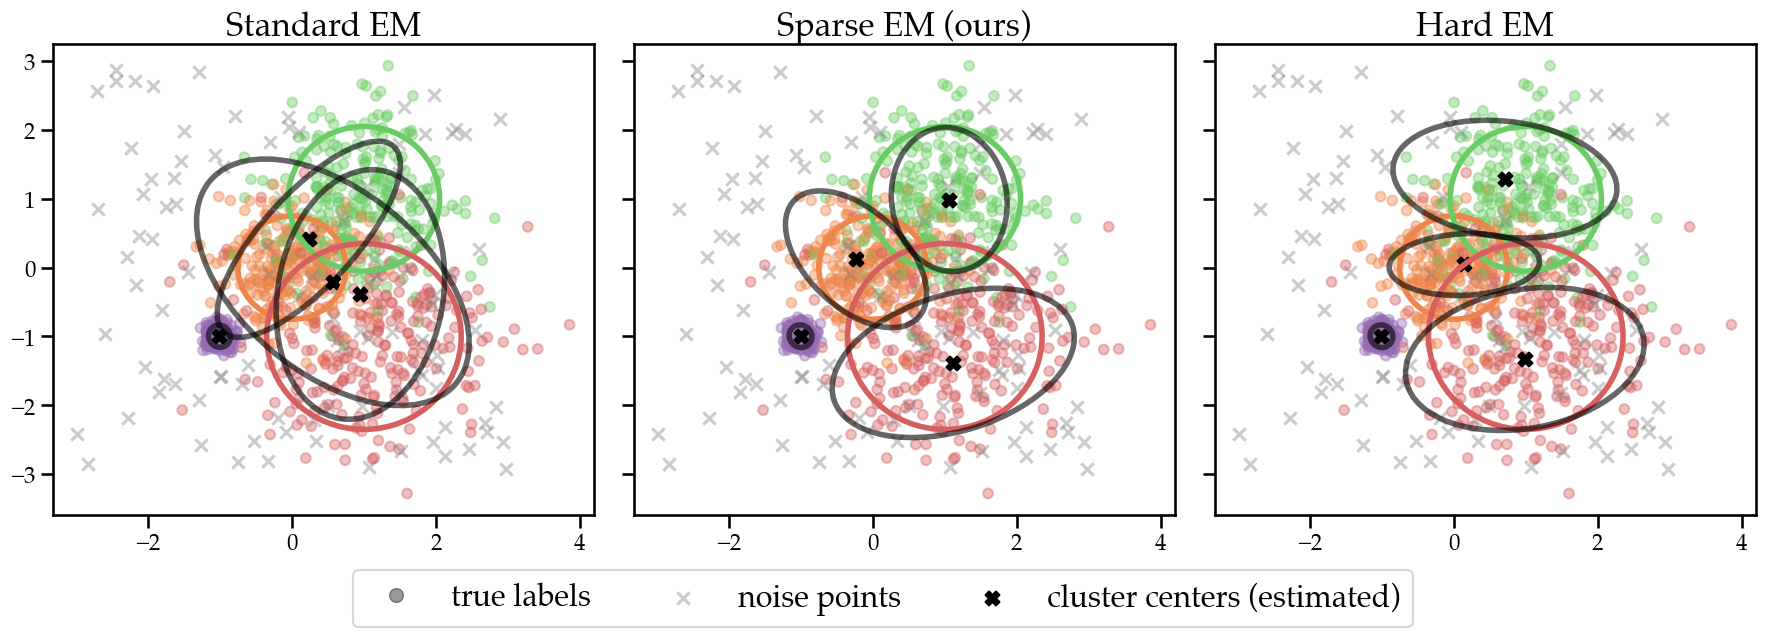

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import mode
import seaborn as sns

# Apply seaborn style
sns.set_context("talk")
#sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['mathtext.fontset'] = 'stix'

# Create an ellipse function
def create_ellipse(mean, covariance, color, scale=1):
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    width, height = scale * 2 * np.sqrt(eigenvalues)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', fc='None', lw=4)

# Main plotting function with Seaborn color palette
def plot_clustering_with_ellipses_gt_labels_and_noise(X, labels, mu, covariances, y_true, ax, title, original_centers, original_stds):
    unique_labels = np.unique(y_true)
    cmap = sns.color_palette("muted", len(unique_labels))
    color_mapping = {label: cmap[i % len(cmap)] for i, label in enumerate(unique_labels)}

    noise_mask = y_true == -1
    non_noise_mask = y_true != -1
    colors_non_noise = [color_mapping[label] for label in y_true[non_noise_mask]]
    colors_noise = 'grey'

    scatter_non_noise = ax.scatter(X[non_noise_mask, 0], X[non_noise_mask, 1], 
                                   c=colors_non_noise, s=50, alpha=0.4, label='True Labels')
    scatter_noise = ax.scatter(X[noise_mask, 0], X[noise_mask, 1], 
                               c=colors_noise, marker='x', s=80, alpha=0.4, edgecolors='k', label='Noise Points')

    cluster_centers = ax.scatter(mu[:, 0].numpy(), mu[:, 1].numpy(), s=100, marker="X", color="black", label='Cluster Centers')

    label_mapping = {}
    for cluster in np.unique(labels):
        mask = labels == cluster
        if np.any(y_true[mask] != -1):
            most_common = mode(y_true[mask][y_true[mask] != -1]).mode.item()
            label_mapping[cluster] = most_common
        else:
            label_mapping[cluster] = -1

    # Draw original ellipses (colored ones) first
    for i, (center, std) in enumerate(zip(original_centers, original_stds)):
        ellipse = Ellipse(xy=center, width=3*std, height=3*std, edgecolor=color_mapping[i], fc='None', lw=4, linestyle='-')
        ax.add_patch(ellipse)

    # Draw black ellipses (fitted ones) last so they appear on top
    for i in range(mu.shape[0]):
        if label_mapping[i] == -1:
            continue

        mean = mu[i].numpy()
        covariance = covariances[i].numpy()
        ellipse = create_ellipse(mean, covariance, color_mapping[label_mapping[i]], scale=1.5)
        ellipse.set_alpha(0.6)
        ellipse.set_linewidth(4)
        ax.add_patch(ellipse)

    ax.set_title(title, fontsize=24, fontweight='bold')

    return scatter_non_noise, scatter_noise, cluster_centers

# Subplots creation with shared y-axis and new style
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Original centers and std deviations from synthetic data generation
original_centers = np.array([[0, 0], [1, 1], [1, -1], [-1, -1]])
original_stds = np.array([0.5, 0.7, 0.9, 0.11])

# Plot each subplot and collect handles and labels for the shared legend
handles = []
labels = []

for i, (label_data, mu_data, s_data, title) in enumerate(
    zip([labels_gmm, labels_sparse_gmm, labels_hard_em], 
        [mu_gmm, mu_sparse, mu_hard], 
        [s_gmm, s_sparse, s_hard], 
        ['Standard EM', 'Sparse EM (ours)', 'Hard EM'])):

    scatter_non_noise, scatter_noise, cluster_centers = plot_clustering_with_ellipses_gt_labels_and_noise(
        X.numpy(), label_data, mu_data, s_data, y.numpy(), axs[i], title, original_centers, original_stds)
    
    # Collect legend handles and labels from the first plot
    if i == 0:
        # Replace the marker color for "True Labels" to black in the legend only
        black_dot_for_legend = plt.Line2D([0], [0], marker='o', color='black', markersize=10, alpha=0.4, linestyle='None', label='true labels')
        handles.extend([black_dot_for_legend, scatter_noise, cluster_centers])
        labels.extend(['true labels', 'noise points', 'cluster centers (estimated)'])

# Create a single legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=22)

plt.tight_layout()
plt.savefig('clustering_results.pdf', bbox_inches='tight')
plt.show()
